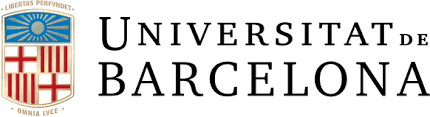

##*Master en Big Data & Data Science*

### **TFM: Clasificación de enfermedades en imágenes médicas utilizando técnicas de Deep Learning**
---

**Alumnos:**
* Santiago Rico Bartolome
* Claudia Alcazar Ureña
* Andres Villa
* Steve Solano Bermudez

**Profesor Tutor:** Ferran Arroyo Vendrell

# Preparacion del Entorno

In [4]:
import numpy as np
import pandas as pd
import cv2 as cv
import matplotlib.pyplot as plt
from matplotlib.colors import Colormap
import seaborn as sns
import os
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow.keras import layers
from keras import utils
from sklearn.metrics import confusion_matrix, classification_report

**Montaje de Google Drive:** Se monta la unidad de Google Drive para acceder a los directorios de entrenamiento y prueba que contienen las imágenes.

In [5]:

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Directorios en local
train_dir = '/content/drive/MyDrive/Training_Bin'
test_dir = '/content/drive/MyDrive/Testing_Bin'

In [7]:
# Paleta de colores en tonos rojos para la matriz de confusion
cmap = sns.color_palette("Reds")
# Propiedades de las imagenes a usar
batch_size = 32
img_height = 180
img_width = 180

# Preparacion de los Datos

In [8]:
# Creacion del set de entrenamiento
train_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 2 classes.
Using 4570 files for training.


In [9]:
# Creacion del set de validacion
val_ds = tf.keras.utils.image_dataset_from_directory(
  train_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 2 classes.
Using 1142 files for validation.


In [10]:
# imprimimos las etiquetas
class_names = train_ds.class_names
print(class_names)

['Notumor', 'Tumor']


**Visualizacion de algunas imagenes**

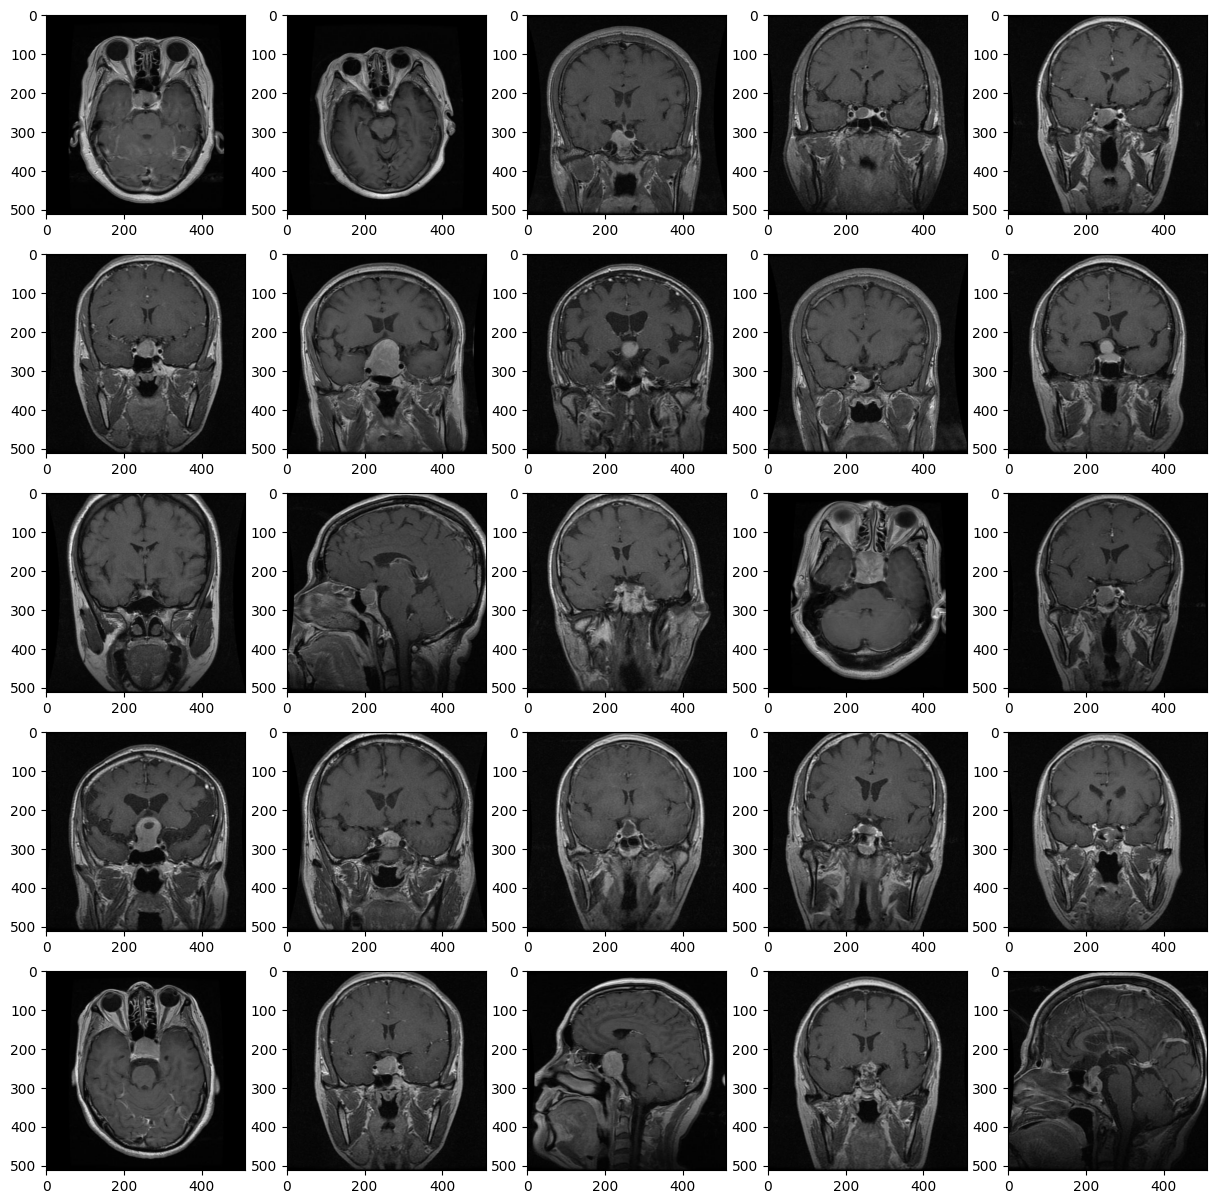

In [ ]:
#Mostrar algunas imagenes con pyplot, en este caso: 'Tumor'
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize=(15,15))

folder = '/content/drive/MyDrive/Training_Bin/Tumor'
images = os.listdir(folder)

for i, nameimg in enumerate(images[:25]):
  plt.subplot(5,5,i+1)
  image = mpimg.imread(folder + '/' + nameimg)
  plt.imshow(image)

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Uso de la tecnica *Data Augmentation*

In [ ]:
# Escalacion de los pixeles en el rango de 0 to 1
normalization_layer = layers.Rescaling(1./255)

In [ ]:
# flip, rotate and zoom

data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomBrightness(0.1),

  ]
)

**Visualizacion de Imagenes despues de Data Augmentation**

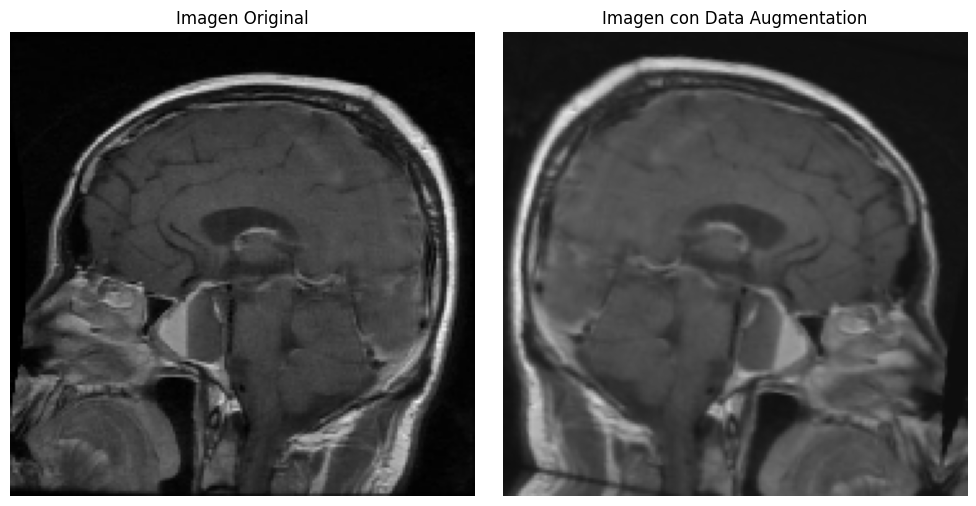

In [ ]:
import random
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.python.ops.numpy_ops import np_config

# Habilitar el comportamiento de numpy en TensorFlow
np_config.enable_numpy_behavior()

# Obtener una imagen al azar del conjunto de entrenamiento
random_class = random.choice(class_names)
random_class_dir = os.path.join(train_dir, random_class)
random_image_path = random.choice(os.listdir(random_class_dir))
image_path = os.path.join(random_class_dir, random_image_path)

# Cargar la imagen original y redimensionarla
image = load_img(image_path, target_size=(img_height, img_width))
image_array = img_to_array(image)

# Aplicar data augmentation a la imagen
augmented_image_array = data_augmentation(np.expand_dims(image_array, 0))
augmented_image = augmented_image_array[0]

# Normalizar los valores de píxeles al rango [0, 1]
image_array /= 255.0
augmented_image /= 255.0

# Mostrar la imagen original y la imagen con data augmentation
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(image_array)
axes[0].set_title("Imagen Original")
axes[0].axis("off")
axes[1].imshow(augmented_image)
axes[1].set_title("Imagen con Data Augmentation")
axes[1].axis("off")

plt.tight_layout()
plt.show()





**Resumen de Transformaciones usadas durante Data Augmentation**

In [ ]:
print(data_augmentation.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip (RandomFlip)    (None, 180, 180, 3)       0         
                                                                 
 random_rotation (RandomRota  (None, 180, 180, 3)      0         
 tion)                                                           
                                                                 
 random_zoom (RandomZoom)    (None, 180, 180, 3)       0         
                                                                 
 random_contrast (RandomCont  (None, 180, 180, 3)      0         
 rast)                                                           
                                                                 
 random_brightness (RandomBr  (None, 180, 180, 3)      0         
 ightness)                                                       
                                                        

# Entrenamiento del Modelo

In [ ]:
# Cracion del modelo con Redes Neuronales Convolucionales (CNN)
num_classes = len(class_names)#2 clases

from tensorflow.keras.layers import Dropout

model_with_dropout = keras.Sequential([
    data_augmentation,
    normalization_layer,
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    Dropout(0.3),  # Capa de dropout
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    Dropout(0.3),  # Capa de dropout
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    Dropout(0.5),  # Capa de dropout
    layers.Dense(num_classes)
])



In [ ]:
# Compilar
from tensorflow.keras.optimizers import Adam

new_learning_rate = 0.001  # Nueva tasa de aprendizaje
optimizer_with_new_lr = Adam(learning_rate=new_learning_rate)

model_with_dropout.compile(optimizer=optimizer_with_new_lr,
                          loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                          metrics=['accuracy'])



In [ ]:
model_with_dropout.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 180, 180, 3)       0         
                                                                 
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 90, 90, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 90, 90, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                      

# Early Stopping

Se utiliza la tecnica de Early Stopping

El "early stopping" es una estrategia que permite detener el entrenamiento del modelo antes de completar todas las épocas (iteraciones) previstas si no se observa una mejora en el desempeño del modelo en el conjunto de validación. Esto evita el sobreajuste y ayuda a encontrar el punto óptimo en el que el modelo generaliza mejor

In [ ]:
# Model Checkpoint
checkpoint_cb = keras.callbacks.ModelCheckpoint(
    "/content/drive/MyDrive/TFM_CNN_Bin.h5"
)
early_stopping_cb = keras.callbacks.EarlyStopping(
    patience=3,
    restore_best_weights=True
)

## Verificamos si hay una GPU Disponible para entrenar nuestro modelo

In [ ]:
import tensorflow as tf
from tensorflow.python.client import device_lib


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Configura la GPU para el crecimiento de la memoria si es necesario
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

    # Imprime información sobre las GPUs disponibles
    print("GPU(s) disponibles:")
    for gpu in gpus:
        print(gpu)
else:
    print("No se encontraron GPUs.")


Physical devices cannot be modified after being initialized
GPU(s) disponibles:
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
epochs = 30
history = model_with_dropout.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[
        checkpoint_cb,
        early_stopping_cb
    ]
)
#  modelo guardado con los mejores pesos (determinados por el "early stopping") se guarda nuevamente en un archivo llamado "TFM_CNNv_Bin.h5" en el directorio actual
model_with_dropout.save("TFM_CNNv_Bin.h5")

Epoch 1/30
143/143 [==============================] - 910s 1s/step - loss: 0.5709 - accuracy: 0.7442 - val_loss: 0.2576 - val_accuracy: 0.9002
Epoch 2/30
143/143 [==============================] - 6s 41ms/step - loss: 0.2692 - accuracy: 0.9009 - val_loss: 0.1971 - val_accuracy: 0.9361
Epoch 3/30
143/143 [==============================] - 4s 31ms/step - loss: 0.2113 - accuracy: 0.9333 - val_loss: 0.1503 - val_accuracy: 0.9501
Epoch 4/30
143/143 [==============================] - 5s 33ms/step - loss: 0.1910 - accuracy: 0.9376 - val_loss: 0.1398 - val_accuracy: 0.9466
Epoch 5/30
143/143 [==============================] - 5s 32ms/step - loss: 0.1670 - accuracy: 0.9442 - val_loss: 0.1472 - val_accuracy: 0.9475
Epoch 6/30
143/143 [==============================] - 4s 31ms/step - loss: 0.1538 - accuracy: 0.9488 - val_loss: 0.1327 - val_accuracy: 0.9536
Epoch 7/30
143/143 [==============================] - 5s 33ms/step - loss: 0.1447 - accuracy: 0.9514 - val_loss: 0.1233 - val_accuracy: 0.9580

# Curvas de Rendimiento

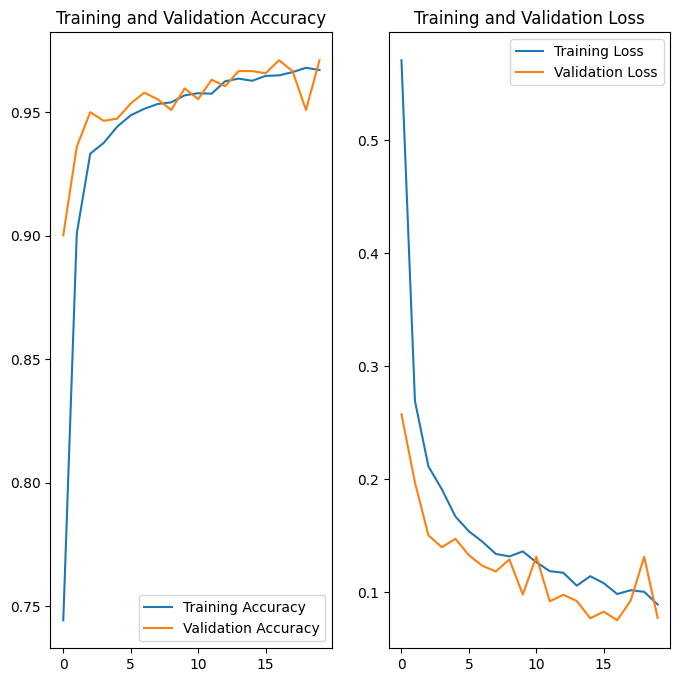

In [ ]:
# Grafico de las curva de entrenamiento: train y validation accuracy & loss
epochs = len(history.epoch) # epochs completadas por el early stopping
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

# Grafica training and validation accuracy
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Grafica training and validation loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
# Obtener las etiquetas reales del conjunto de pruebas
y_test_actual = np.array([])
for _, y in val_ds:
    y_test = np.array(y)
    y_test_actual = np.concatenate((y_test_actual, y_test))


1/1 [==============================] - 0s 134ms/step


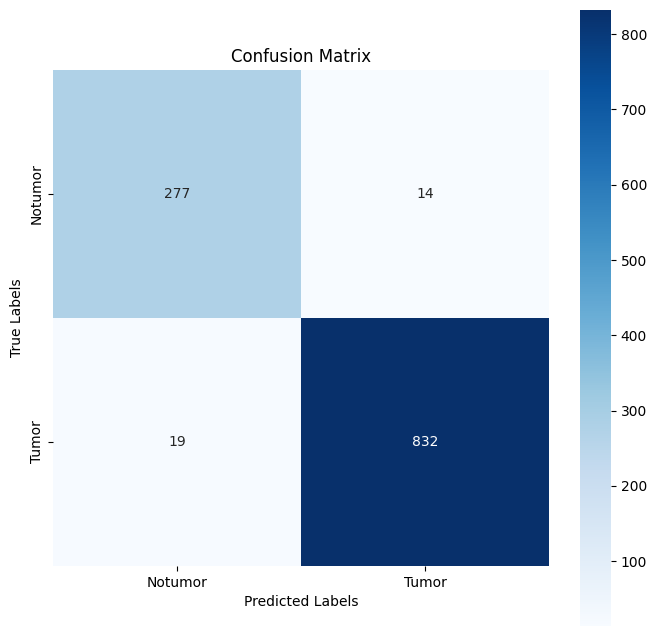

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generar predicciones en el conjunto de pruebas
y_pred_actual = np.array([])
for x, _ in val_ds:
    predictions = model_with_dropout.predict(x)
    normalized_predictions = tf.nn.softmax(predictions)  # Aplicacion de softmax para obtener probabilidades
    y_pred = np.argmax(normalized_predictions, axis=1)
    y_pred_actual = np.concatenate((y_pred_actual, y_pred))

# matriz de confusión
conf_matrix = confusion_matrix(y_test_actual, y_pred_actual)

# Visualizacion de la matriz de confusión
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", square=True,
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()




In [ ]:
from sklearn.metrics import classification_report

# Obtener el informe de clasificación
report = classification_report(y_test_actual, y_pred_actual, target_names=class_names)

# Imprimir el informe
print(report)


              precision    recall  f1-score   support

     Notumor       0.94      0.95      0.94       291
       Tumor       0.98      0.98      0.98       851

    accuracy                           0.97      1142
   macro avg       0.96      0.96      0.96      1142
weighted avg       0.97      0.97      0.97      1142



## Pruebas con Bulk Uploading

In [ ]:
import tensorflow as tf
import numpy as np
import os
import cv2
from tabulate import tabulate

def get_predictions(test_folder, model):
    img_height, img_width = 180, 180  # Tamaño de las imágenes de entrada del modelo
    class_names = ['Notumor', 'Tumor'] # Nombres de las clases

    # Función para preprocesar una imagen
    def preprocess_image(image):
        image = cv2.imread(image)  # Leer la imagen
        image = cv2.resize(image, (img_width, img_height))  # Redimensionar la imagen al tamaño de entrada del modelo

        return image

    # Obtener la lista de archivos de imágenes en la carpeta de prueba
    image_files = [os.path.join(test_folder, file) for file in os.listdir(test_folder) if
                   file.endswith((".bmp", ".gif", ".jpeg", ".jpg", ".png"))]

    for image_file in image_files:
        image = preprocess_image(image_file)
        image = np.expand_dims(image, axis=0)  # Agregar una dimensión adicional para el batch
        predictions = model.predict(image)
        scores = tf.nn.softmax(predictions)

        img = cv2.cvtColor(cv2.imread(image_file), cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
        plt.show()

        classes = []
        probabilities = []
        for i, class_name in enumerate(class_names):
            class_index = i
            probability = scores[0][class_index] * 100
            classes.append(class_name)
            probabilities.append("%.3f" % probability)

        # Ordenar la tabla por la columna de probabilidades en orden descendente
        sorted_data = sorted(zip(classes, probabilities), key=lambda x: float(x[1]), reverse=True)
        sorted_classes, sorted_probabilities = zip(*sorted_data)

        data = {'Class': sorted_classes, 'Probability (%)': sorted_probabilities}
        table = tabulate(data, headers='keys', tablefmt='fancy_grid')
        print(table)
        print()

1/1 [==============================] - 0s 84ms/step


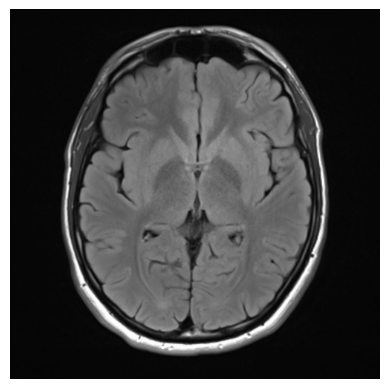

╒═════════╤═══════════════════╕
│ Class   │   Probability (%) │
╞═════════╪═══════════════════╡
│ Notumor │            99.961 │
├─────────┼───────────────────┤
│ Tumor   │             0.039 │
╘═════════╧═══════════════════╛

1/1 [==============================] - 0s 21ms/step


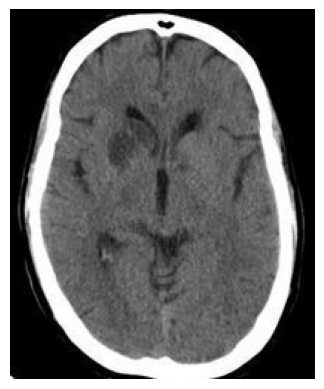

╒═════════╤═══════════════════╕
│ Class   │   Probability (%) │
╞═════════╪═══════════════════╡
│ Notumor │            70.437 │
├─────────┼───────────────────┤
│ Tumor   │            29.563 │
╘═════════╧═══════════════════╛

1/1 [==============================] - 0s 31ms/step


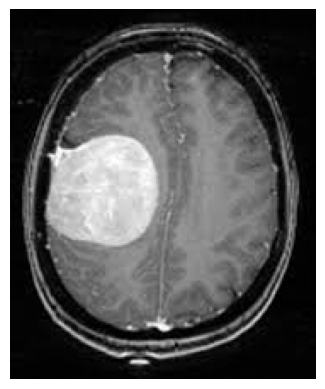

╒═════════╤═══════════════════╕
│ Class   │   Probability (%) │
╞═════════╪═══════════════════╡
│ Notumor │            99.735 │
├─────────┼───────────────────┤
│ Tumor   │             0.265 │
╘═════════╧═══════════════════╛

1/1 [==============================] - 0s 35ms/step


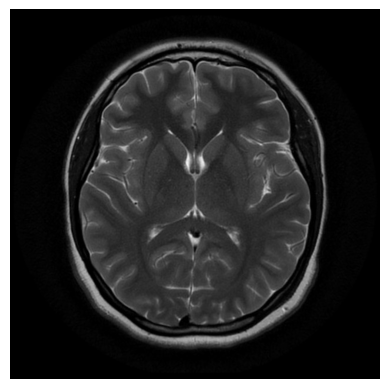

╒═════════╤═══════════════════╕
│ Class   │   Probability (%) │
╞═════════╪═══════════════════╡
│ Notumor │            99.666 │
├─────────┼───────────────────┤
│ Tumor   │             0.334 │
╘═════════╧═══════════════════╛

1/1 [==============================] - 0s 41ms/step


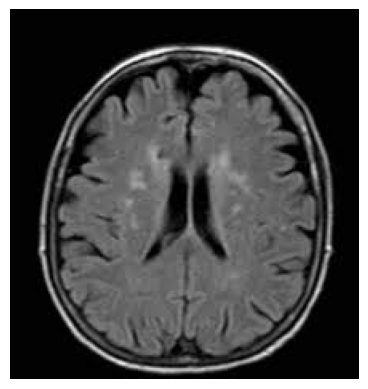

╒═════════╤═══════════════════╕
│ Class   │   Probability (%) │
╞═════════╪═══════════════════╡
│ Notumor │            99.823 │
├─────────┼───────────────────┤
│ Tumor   │             0.177 │
╘═════════╧═══════════════════╛

1/1 [==============================] - 0s 32ms/step


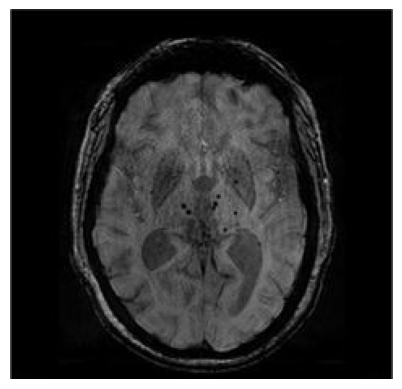

╒═════════╤═══════════════════╕
│ Class   │   Probability (%) │
╞═════════╪═══════════════════╡
│ Notumor │            99.397 │
├─────────┼───────────────────┤
│ Tumor   │             0.603 │
╘═════════╧═══════════════════╛

1/1 [==============================] - 0s 29ms/step


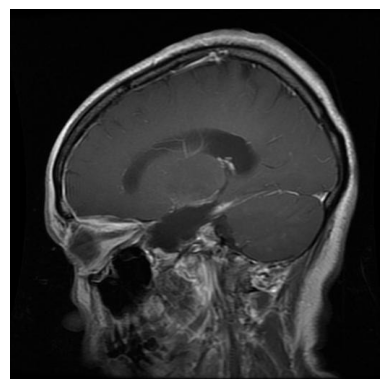

╒═════════╤═══════════════════╕
│ Class   │   Probability (%) │
╞═════════╪═══════════════════╡
│ Tumor   │            99.966 │
├─────────┼───────────────────┤
│ Notumor │             0.034 │
╘═════════╧═══════════════════╛

1/1 [==============================] - 0s 28ms/step


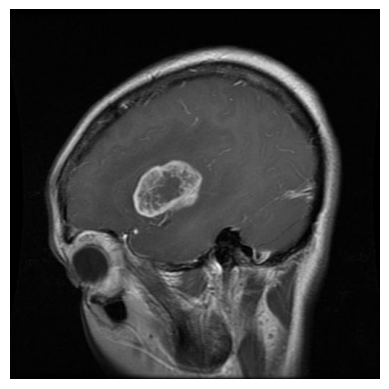

╒═════════╤═══════════════════╕
│ Class   │   Probability (%) │
╞═════════╪═══════════════════╡
│ Tumor   │               100 │
├─────────┼───────────────────┤
│ Notumor │                 0 │
╘═════════╧═══════════════════╛

1/1 [==============================] - 0s 35ms/step


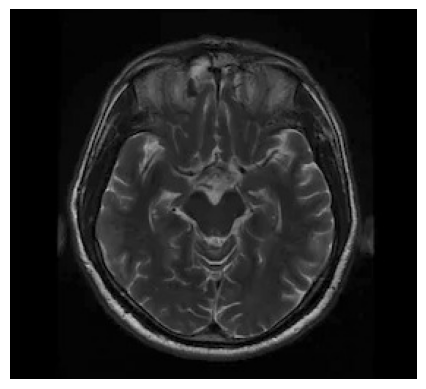

╒═════════╤═══════════════════╕
│ Class   │   Probability (%) │
╞═════════╪═══════════════════╡
│ Notumor │            95.207 │
├─────────┼───────────────────┤
│ Tumor   │             4.793 │
╘═════════╧═══════════════════╛

1/1 [==============================] - 0s 30ms/step


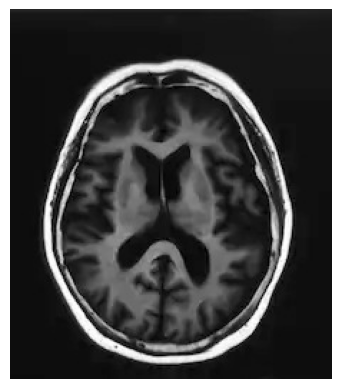

╒═════════╤═══════════════════╕
│ Class   │   Probability (%) │
╞═════════╪═══════════════════╡
│ Notumor │            96.395 │
├─────────┼───────────────────┤
│ Tumor   │             3.605 │
╘═════════╧═══════════════════╛



In [ ]:
test_folder = '/content/drive/MyDrive/Patient File'
model = tf.keras.models.load_model('/content/TFM_CNNv_Bin.h5')

get_predictions(test_folder, model)


## Deteccion de Anomalias

### Autoencoders

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.layers import BatchNormalization, Conv2D, Conv2DTranspose, LeakyReLU, Activation, Flatten, Dense, Reshape, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import cv2

# Configuración de parámetros
EPOCHS = 20
INIT_LR = 1e-3
BS = 32
target_size = (180, 180)

# Directorios de los conjuntos de datos
train_dir = '/content/drive/MyDrive/Training_Bin'
test_dir = '/content/drive/MyDrive/Testing_Bin'

# Cargar y preprocesar datos de entrenamiento
train_datagen = ImageDataGenerator(rescale=1.0/255.0)
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=BS,
    class_mode='input',
    shuffle=True
)
train_steps_per_epoch = train_generator.samples // BS

# Cargar y preprocesar datos de prueba
test_datagen = ImageDataGenerator(rescale=1.0/255.0)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=target_size,
    batch_size=BS,
    class_mode='input',
    shuffle=False
)
test_steps_per_epoch = test_generator.samples // BS

# Construir el autoencoder
def build_autoencoder():
    inputShape = target_size + (3,)  # Tamaño de imagen y canales RGB
    chanDim = -1

    inputs = Input(shape=inputShape)
    x = inputs

    # Encoder
    x = Conv2D(32, (3, 3), strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(axis=chanDim)(x)

    volumeSize = x.shape
    x = Flatten()(x)
    latent = Dense(16)(x)

    # Decoder
    latentInputs = Input(shape=(16,))
    x = Dense(np.prod(volumeSize[1:]))(latentInputs)
    x = Reshape((volumeSize[1], volumeSize[2], volumeSize[3]))(x)

    x = Conv2DTranspose(32, (3, 3), strides=2, padding="same")(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(axis=chanDim)(x)

    x = Conv2DTranspose(3, (3, 3), padding="same")(x)
    outputs = Activation("sigmoid")(x)

    encoder = Model(inputs, latent, name="encoder")
    decoder = Model(latentInputs, outputs, name="decoder")
    autoencoder = Model(inputs, decoder(encoder(inputs)), name="autoencoder")

    return encoder, decoder, autoencoder

# Construir y compilar el autoencoder
encoder, decoder, autoencoder = build_autoencoder()
opt = Adam(learning_rate=INIT_LR)
autoencoder.compile(loss="mse", optimizer=opt)

# Entrenar el autoencoder
H = autoencoder.fit(
    train_generator,
    steps_per_epoch=train_steps_per_epoch,
    validation_data=test_generator,
    validation_steps=test_steps_per_epoch,
    epochs=EPOCHS
)




Found 5712 images belonging to 2 classes.
Found 1311 images belonging to 2 classes.
Epoch 1/20
178/178 [==============================] - 96s 169ms/step - loss: 0.0485 - val_loss: 0.0368
Epoch 2/20
178/178 [==============================] - 28s 156ms/step - loss: 0.0187 - val_loss: 0.0294
Epoch 3/20
178/178 [==============================] - 28s 156ms/step - loss: 0.0166 - val_loss: 0.0209
Epoch 4/20
178/178 [==============================] - 29s 162ms/step - loss: 0.0153 - val_loss: 0.0151
Epoch 5/20
178/178 [==============================] - 36s 200ms/step - loss: 0.0143 - val_loss: 0.0142
Epoch 6/20
178/178 [==============================] - 29s 160ms/step - loss: 0.0136 - val_loss: 0.0134
Epoch 7/20
178/178 [==============================] - 30s 168ms/step - loss: 0.0131 - val_loss: 0.0129
Epoch 8/20
178/178 [==============================] - 29s 163ms/step - loss: 0.0126 - val_loss: 0.0124
Epoch 9/20
178/178 [==============================] - 29s 161ms/step - loss: 0.0123 - val_lo

In [ ]:
# Ruta para guardar el modelo
model_path = '/content/drive/MyDrive/autoencoder.h5'

# Guardar el modelo
autoencoder.save(model_path)

print("Modelo guardado en:", model_path)

Modelo guardado en: /content/drive/MyDrive/autoencoder.h5


Ahora usamos scikit-learn para calcular el Error Absoluto Medio (**MAE**) entre pares de imágenes originales y sus imágenes reconstruidas (decodificadas) correspondientes generadas por el autoencoder.

El **MAE** mide la diferencia promedio absoluta entre los valores de pixeles de las dos imágenes, proporcionando asi una medida cuantitativa de qué tan bien el autoencoder puede reconstruir las imágenes originales.

************

In [ ]:
from sklearn.metrics import mean_absolute_error

# Realizar predicciones y visualización
num_samples = 10 #diez muestras para darnos una idea
decoded_images = autoencoder.predict(test_generator)

# Extraer num_samples imágenes originales del generador
original_images = []
for _ in range(num_samples):
    batch = next(test_generator)
    original_images.append(batch[0][0])

# Calcular el MAE para cada par de imágenes
for i in range(num_samples):
    original_img = original_images[i].flatten()  # Aplanar la imagen original
    decoded_img = decoded_images[i].flatten()  # Aplanar la imagen reconstruida
    mae = mean_absolute_error(original_img, decoded_img)
    print(f"MAE entre imagen {i+1}: {mae}")



41/41 [==============================] - 7s 181ms/step
MAE entre imagen 1: 0.14404483139514923
MAE entre imagen 2: 0.12787353992462158
MAE entre imagen 3: 0.0969042256474495
MAE entre imagen 4: 0.12637433409690857
MAE entre imagen 5: 0.12764276564121246
MAE entre imagen 6: 0.1036049947142601
MAE entre imagen 7: 0.09823062270879745
MAE entre imagen 8: 0.12323402613401413
MAE entre imagen 9: 0.25777825713157654
MAE entre imagen 10: 0.24799376726150513


Ahora modificamos un poco el código anterior para calcular el Error Absoluto Medio (MAE) entre todas las imágenes originales y decodificadas generadas por el autoencoder. Estamos procesando todo el conjunto de datos de prueba y calculando el MAE para cada par de imágenes en cada lote, y luego almacenando todos los valores de MAE en una lista llamada all_mae que nos ayudara a contruir un histograma que permitirá visualizar la distribución de los valores de MAE en todas las imágenes de prueba.

In [ ]:
from sklearn.metrics import mean_absolute_error

all_mae = []

for i in range(len(test_generator)):
    batch = next(test_generator)
    original_images = batch[0]
    decoded_images = autoencoder.predict(original_images)

    batch_mae = [mean_absolute_error(original_img.flatten(), decoded_img.flatten()) for original_img, decoded_img in zip(original_images, decoded_images)]
    all_mae.extend(batch_mae)



1/1 [==============================] - 0s 27ms/step


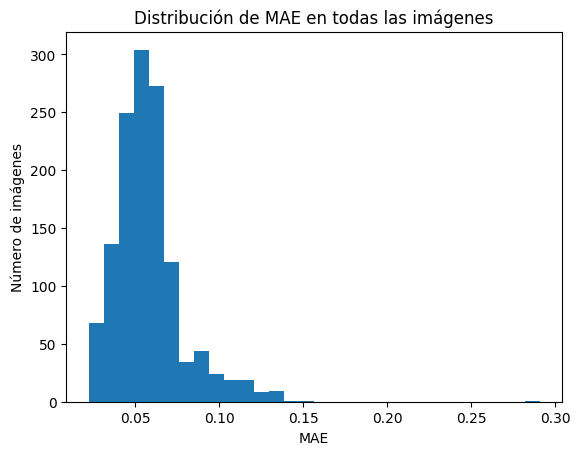

In [ ]:
plt.hist(all_mae, bins=30)
plt.xlabel('MAE')
plt.ylabel('Número de imágenes')
plt.title('Distribución de MAE en todas las imágenes')
plt.show()


En este puntop definimos un umbral basado en el percentil 95 de los valores de Error Absoluto Medio (**MAE**) almacenados en la lista all_mae. Este umbral será utilizado para determinar qué imágenes tienen un **MAE** superior al percentil 95 y, por lo tanto, podrían considerarse anómalas o inusuales en función de la distribución del **MAE**.

In [ ]:
# Definir el umbral, en este caso el percentil 95 de los valores de MAE
threshold = np.percentile(all_mae, 95)
print("Umbral:", threshold)


Umbral: 0.10093236342072487


In [ ]:
anomalies = [i for i, mae in enumerate(all_mae) if mae > threshold]
print("Índices de imágenes anomalías:", anomalies)
len(anomalies)

Índices de imágenes anomalías: [108, 120, 180, 185, 189, 213, 271, 272, 324, 352, 357, 363, 366, 374, 375, 380, 381, 382, 384, 387, 419, 423, 424, 435, 477, 494, 800, 801, 802, 806, 814, 820, 821, 822, 824, 830, 836, 839, 843, 844, 845, 846, 847, 849, 855, 856, 857, 859, 861, 864, 865, 870, 874, 878, 881, 884, 885, 888, 890, 896, 897, 898, 899, 903, 912, 940]


66

Finalmente  visualizamos las imágenes anómalas, es decir, aquellas cuyo Error Absoluto Medio (**MAE**) está por encima del umbral definido. En este caso, se están visualizando las primeras num_anomalies_to_visualize imágenes anómalas.

1/1 [==============================] - 0s 189ms/step


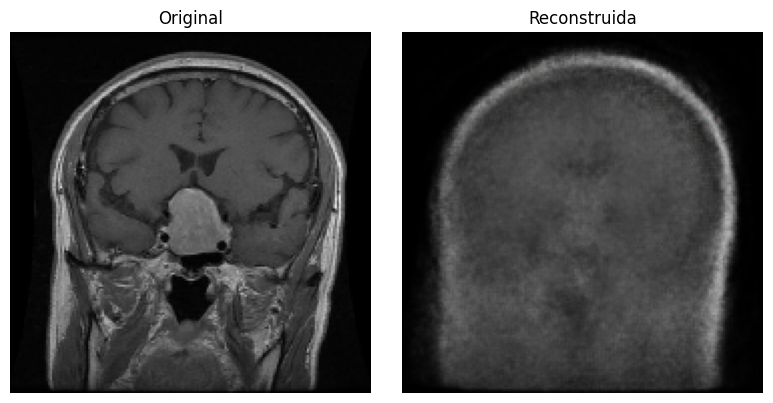

1/1 [==============================] - 0s 87ms/step


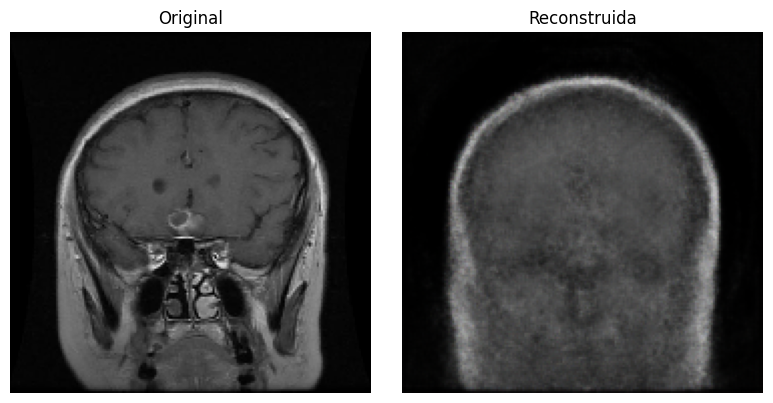

1/1 [==============================] - 0s 58ms/step


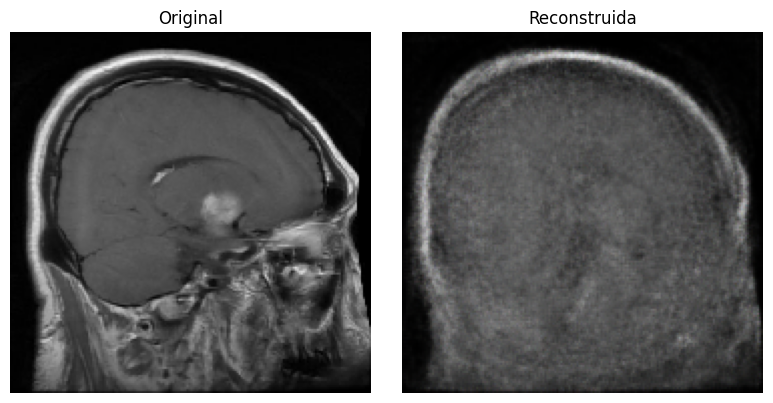

1/1 [==============================] - 0s 73ms/step


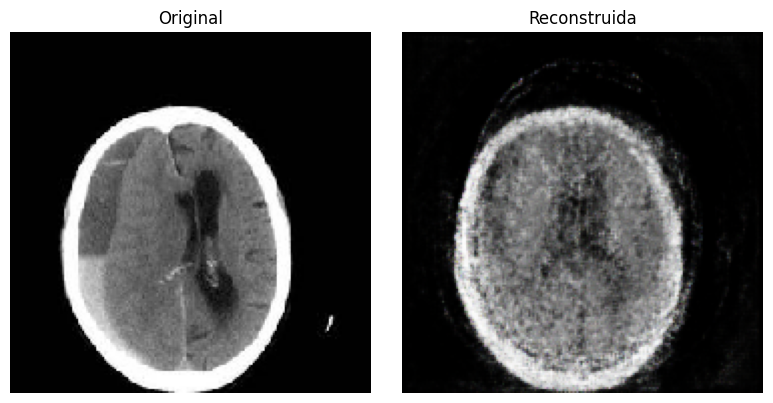

1/1 [==============================] - 0s 80ms/step


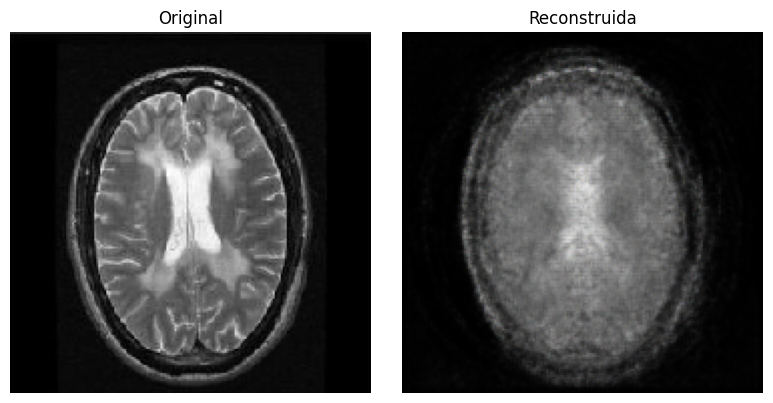

1/1 [==============================] - 0s 71ms/step


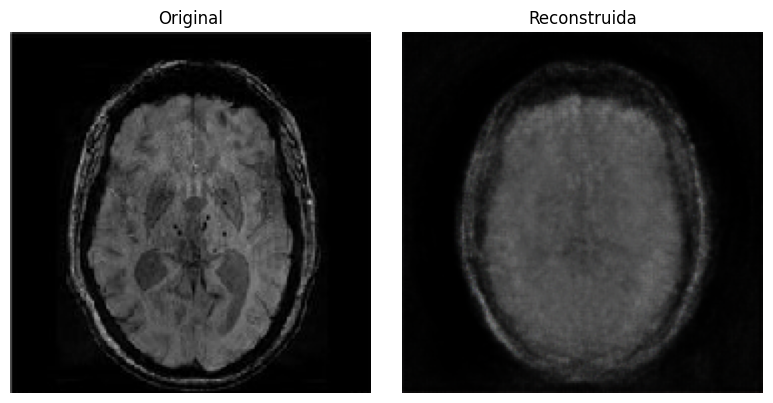

1/1 [==============================] - 0s 51ms/step


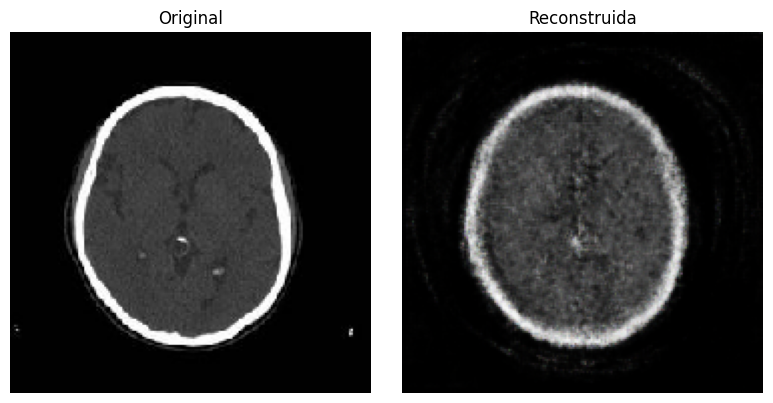

1/1 [==============================] - 0s 24ms/step


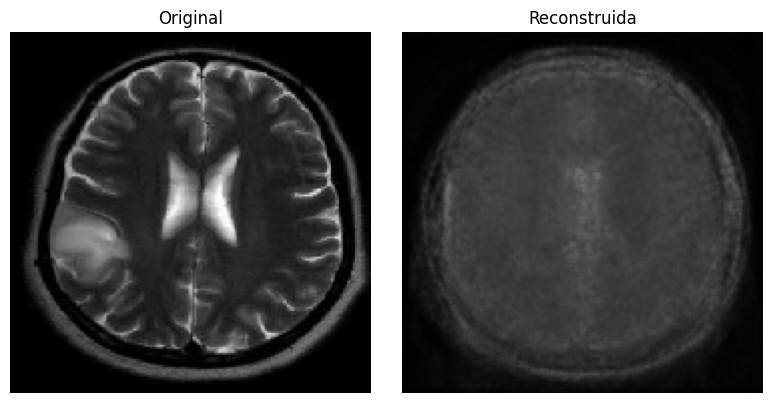

1/1 [==============================] - 0s 25ms/step


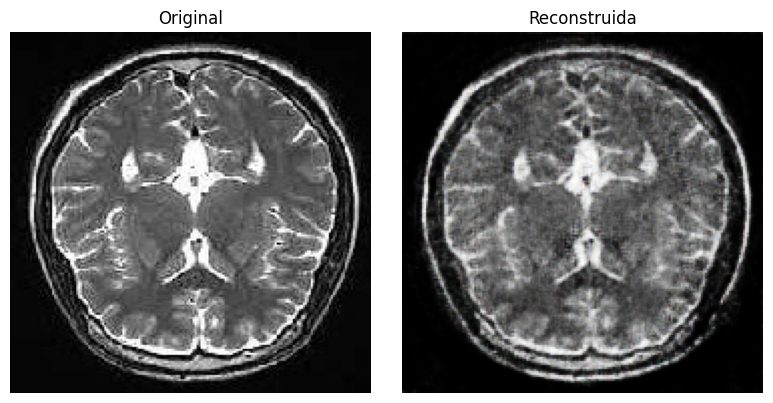

1/1 [==============================] - 0s 34ms/step


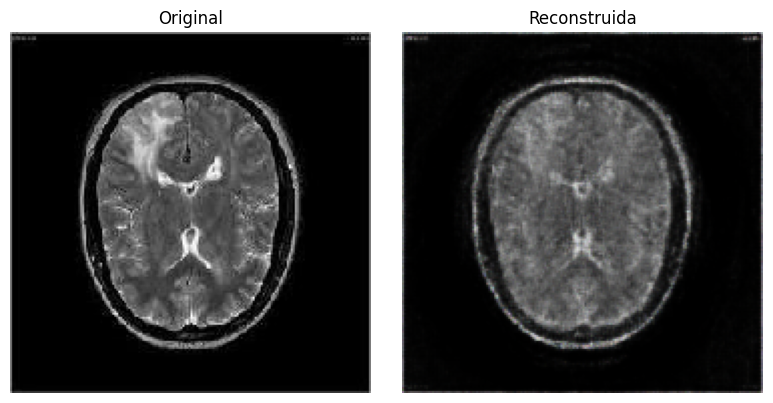

In [ ]:
num_anomalies_to_visualize = 10 #se puede pasar al numero total usando len(anomalies)

for anomaly_idx in anomalies[:num_anomalies_to_visualize]:
    original_img = next(test_generator)[0][0]  # Obtener el siguiente lote de imágenes y seleccionar la primera imagen
    decoded_img = autoencoder.predict(original_img[np.newaxis])[0]

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(original_img)
    plt.title("Original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(decoded_img)
    plt.title("Reconstruida")
    plt.axis("off")

    plt.tight_layout()
    plt.show()



La visualización muestra las imágenes originales en la columna izquierda y las imágenes reconstruidas en la columna derecha. Si las imágenes reconstruidas se parecen a las originales, significa que el autoencoder ha logrado una buena reconstrucción, y no se han detectado anomalías. Por otro lado, si las imágenes reconstruidas se ven significativamente diferentes de las originales, podría indicar que el autoencoder ha detectado algunas anomalías o patrones inusuales en los datos.

En resumen, un autoencoder para la detección de anomalías en modelos de clasificación de imágenes opera mediante la identificación de patrones y características en imágenes normales durante el entrenamiento, y luego compara la similitud entre las imágenes de entrada y las imágenes reconstruidas para detectar anomalías en nuevas instancias

## AUC-ROC

1/1 [==============================] - 0s 96ms/step


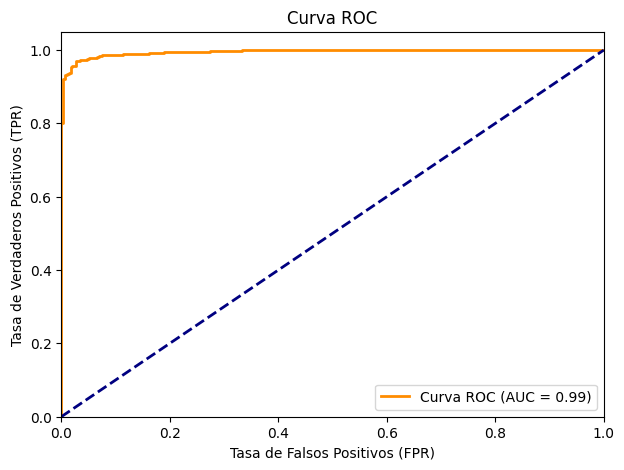

AUC-ROC: 0.99


In [14]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import roc_curve, auc

# Cargar el modelo desde Google Drive (ajusta la ruta según tu modelo)
model_path = '/content/drive/MyDrive/TFM_CNN_Bin.h5'
model = tf.keras.models.load_model(model_path)

# Obtener las etiquetas verdaderas y las probabilidades de predicción en el conjunto de validación
y_true = []
y_scores = []

for x, y in val_ds:
    y_true.extend(y.numpy())
    predictions = model.predict(x)
    y_scores.extend(predictions)

# Convierte y_scores a un arreglo numpy
y_scores = np.array(y_scores)

# Calcular la Curva ROC
fpr, tpr, _ = roc_curve(y_true, y_scores[:, 1])  # 1 representa la clase positiva, ajusta según tus necesidades
roc_auc = auc(fpr, tpr)

# Visualizar la Curva ROC y mostrar el AUC-ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='Curva ROC (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

# Muestra el valor del AUC-ROC
print(f'AUC-ROC: {roc_auc:.2f}')


## Grafico de Ganancias Acumuladas

1/1 [==============================] - 0s 307ms/step


<Figure size 700x700 with 0 Axes>

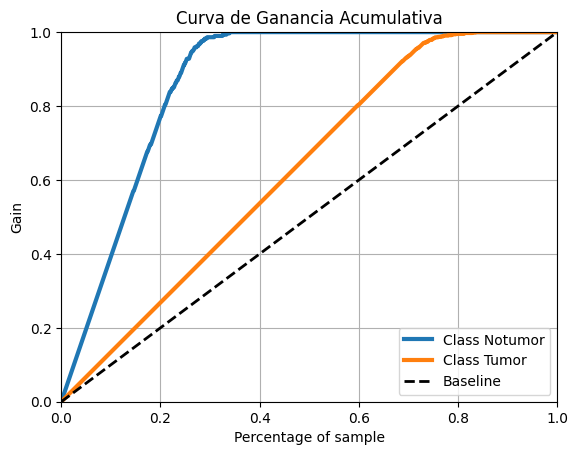

In [13]:
import tensorflow as tf
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

# Cargar el modelo desde Google Drive (ajusta la ruta según tu modelo)
model_path = '/content/drive/MyDrive/TFM_CNN_Bin.h5'
model = tf.keras.models.load_model(model_path)

# Obtener las etiquetas verdaderas y las probabilidades de predicción en el conjunto de validación
y_true = []
y_scores = []

for x, y in val_ds:
    y_true.extend(y.numpy())
    predictions = model.predict(x)
    y_scores.extend(predictions)

# Convierte y_scores a un arreglo numpy
y_scores = np.array(y_scores)

# Reemplazar los valores numéricos con los nombres de clase correspondientes
class_names = ['Notumor', 'Tumor']
y_true = [class_names[y] for y in y_true]

# Calcular la Curva de Ganancia Acumulativa con etiquetas de clase en lugar de valores numéricos
plt.figure(figsize=(7, 7))
skplt.metrics.plot_cumulative_gain(y_true, y_scores)
plt.title("Curva de Ganancia Acumulativa")
plt.show()


## Curva Lift

1/1 [==============================] - 0s 363ms/step


<Figure size 700x700 with 0 Axes>

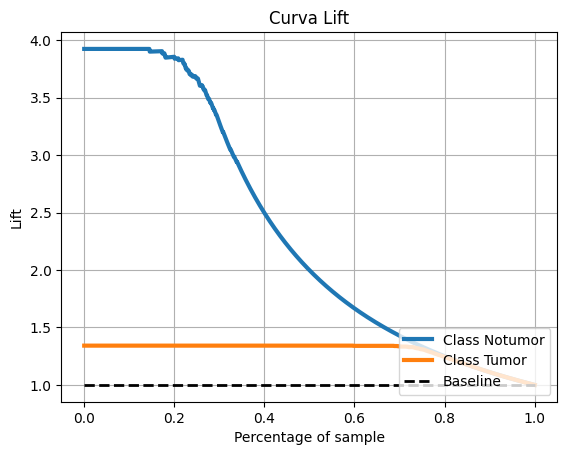

In [12]:
import tensorflow as tf
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

# Cargar el modelo desde Google Drive (ajusta la ruta según tu modelo)
model_path = '/content/drive/MyDrive/TFM_CNN_Bin.h5'
model = tf.keras.models.load_model(model_path)

# Obtener las etiquetas verdaderas y las probabilidades de predicción en el conjunto de validación
y_true = []
y_scores = []

for x, y in val_ds:
    y_true.extend(y.numpy())
    predictions = model.predict(x)
    y_scores.extend(predictions)

# Convierte y_scores a un arreglo numpy
y_scores = np.array(y_scores)

# Reemplazar los valores numéricos con los nombres de clase correspondientes
class_names = ['Notumor', 'Tumor']
y_true = [class_names[y] for y in y_true]

# Calcular la Curva Lift con etiquetas de clase en lugar de valores numéricos
plt.figure(figsize=(7, 7))
skplt.metrics.plot_lift_curve(y_true, y_scores)
plt.title("Curva Lift")
plt.show()


## Gráfico de KS (Kolmogorov-Smirnov) Statistics

1/1 [==============================] - 0s 452ms/step


<Figure size 700x500 with 0 Axes>

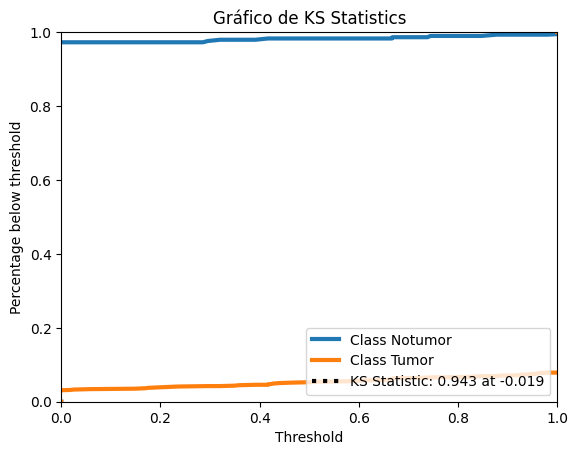

In [12]:
import tensorflow as tf
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

# Cargar el modelo desde Google Drive (ajusta la ruta según tu modelo)
model_path = '/content/drive/MyDrive/TFM_CNN_Bin.h5'
model = tf.keras.models.load_model(model_path)

# Obtener las etiquetas verdaderas y las probabilidades de predicción en el conjunto de validación
y_true = []
y_scores = []

for x, y in val_ds:
    y_true.extend(y.numpy())
    predictions = model.predict(x)
    y_scores.extend(predictions)

# Convierte y_scores a un arreglo numpy
y_scores = np.array(y_scores)

# Reemplazar los valores numéricos con los nombres de clase correspondientes
class_names = ['Notumor', 'Tumor']
y_true = [class_names[y] for y in y_true]

# Calcular el gráfico de KS Statistics con nombres de clase en lugar de valores numéricos
plt.figure(figsize=(7, 5))
skplt.metrics.plot_ks_statistic(y_true, y_scores)
plt.title("Gráfico de KS Statistics")
plt.show()


El gráfico de KS Statistics muestra una diferencia significativa entre las distribuciones acumulativas de probabilidad positiva y negativa, con un valor de KS de 0.93. Este valor sugiere que el modelo es capaz de distinguir eficazmente entre las clases y alcanza su máxima diferencia acumulativa en un umbral de clasificación de -0.019. Este umbral negativo indica que el modelo logra una fuerte separación entre las clases, lo que es beneficioso para la clasificación. En resumen, los resultados indican un rendimiento sólido del modelo en la clasificación binaria.







1/1 [==============================] - 0s 80ms/step


<Figure size 700x500 with 0 Axes>

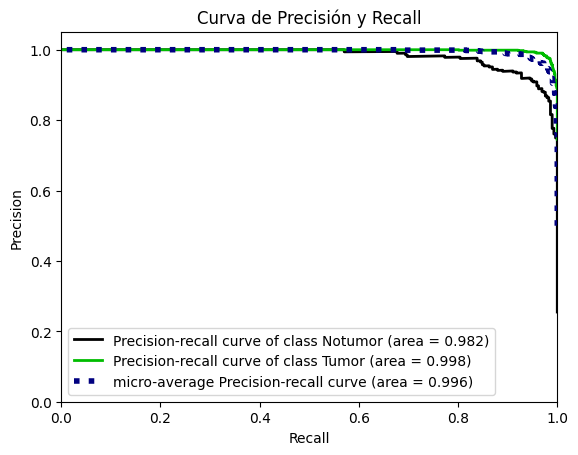

In [13]:
import tensorflow as tf
import scikitplot as skplt
import matplotlib.pyplot as plt
import numpy as np

# Cargar el modelo desde Google Drive (ajusta la ruta según tu modelo)
model_path = '/content/drive/MyDrive/TFM_CNN_Bin.h5'
model = tf.keras.models.load_model(model_path)

# Obtener las etiquetas verdaderas y las probabilidades de predicción en el conjunto de validación
y_true = []
y_scores = []

for x, y in val_ds:
    y_true.extend(y.numpy())
    predictions = model.predict(x)
    y_scores.extend(predictions)

# Convierte y_scores a un arreglo numpy
y_scores = np.array(y_scores)

# Reemplazar los valores numéricos con los nombres de clase correspondientes
class_names = ['Notumor', 'Tumor']
y_true = [class_names[y] for y in y_true]

# Calcular la Curva de Precisión y Recall
plt.figure(figsize=(7, 5))
skplt.metrics.plot_precision_recall(y_true, y_scores)
plt.title("Curva de Precisión y Recall")
plt.show()


**Curva de Precision-Recall para "Notumor" (class Notumor):** La curva negra representa la precisión y el recall para la clase "Notumor". Un área bajo la curva (AUC) de 0.982 indica una elevada capacidad del modelo para predecir correctamente ejemplos de la clase "Notumor". En otras palabras, el modelo tiene una alta precisión y es capaz de recuperar la mayoría de los ejemplos de la clase "Notumor".

**Curva de Precision-Recall para "Tumor" (class Tumor):** La curva verde representa la precisión y el recall para la clase "Tumor". Un AUC de 0.998 indica un rendimiento muy considerable en la predicción de ejemplos de la clase "Tumor". El modelo tiene una alta precisión y es altamente eficaz en la recuperación de ejemplos de la clase "Tumor".

**Curva Precision-Recall general:** La línea de puntos representa la curva de Precision-Recall general, que considera tanto la clase "Notumor" como la clase "Tumor". Un AUC de 0.996 indica un rendimiento general excelente del modelo en la clasificación binaria, equilibrando eficazmente la precisión y el recall en ambas clases.